# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}

**soft voting**

$ \hat{y} = (\sum_{i = 0}^M \frac{\mu_i}{\sigma_i + \epsilon} )(\sum_i \sigma_i + \epsilon )$

**deregularization**
reduce $\lambda$ wrt the optimal value in an estimator on the same dataset; and make it fixed, instead of having the GPR optimize it. The idea is to reduce bias in a single estimator and average them out to surpress the increased variance. 

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    ## colab
    import sys,os
    !git clone -b mpi https://github.com/tlpss/ML-Project2.git
    sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X
from aggregating.models import SoftBagger

## Parameter Configuration

In [6]:
np.random.seed(2020)

In [7]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [8]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [9]:
#kernel FIX LAMBDA
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0]+lambda_range[1])/2,noise_level_bounds = lambda_range)


In [10]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [11]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

In [12]:
X_test.shape

(50000, 1, 2)

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [13]:
#reference error: no ensemble; no fixing lambda

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,N_test,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 35060
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.11480572178179495
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.17124000725126198
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.14258894235284092
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.12155161802293622
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.14485188343340394
{'M': 1, 'train_size_alpha': 1.0} -> [0.11480572178179495, 0.17124000725126198, 0.14258894235284092, 0.12155161802293622, 0.14485188343340394]
0.1390076345684476


In [14]:
#get "optimal" lambda
#kernel_fixed = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) + WhiteKernel(noise_level= 1e-5 , noise_level_bounds='fixed')
model = GaussianProcessRegressor(kernel)  
indices = np.random.choice(N_train,int(N_train*0.4),replace=True)
model.fit(flatten_X(X_train[indices]),y_train[indices])
print(model.kernel_.get_params())

{'k1': RBF(length_scale=0.776), 'k2': WhiteKernel(noise_level=5e-06), 'k1__length_scale': 0.7761505257063328, 'k1__length_scale_bounds': array([ 0.77615053, 77.61505257]), 'k2__noise_level': 4.999999999999999e-06, 'k2__noise_level_bounds': (5e-06, 5.0)}


In [15]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

lambda_ = 1e-5

kernel_fixed = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= 1e-5 , noise_level_bounds="fixed")
# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel_fixed,copy_X_train=False)) ## USE THE FIXED LAMBDA KERNEL
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count()-2) #hyperthreading 
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 33840
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 18096
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 23328
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 31132
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.2} -> thread id = 33876
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 27276
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.4} -> thread id = 27364
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 15996
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.2} -> thread id = 35544
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 10120
fit
(5000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2) soft predict
(50000, 2)

{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.2170534848611092
 soft predict
(

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 3, 'train_size_alpha': 0.5} , 0 -> 0.1153723018632555
 soft predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.2} , 0 -> 0.11534792739264185
{'M': 1, 'train_size_alpha': 0.4} , 2 -> 0.15881507714176724
{'M': 1, 'train_size_alpha': 0.4} -> [0.13656316970519256, 0.1634964361054732, 0.15881507714176724]
 {'M': 5, 'train_size_alpha': 0.5} -> thread id = 23328
fitlogger {'M': 1, 'train_size_alpha': 0.4}, -> [0.13656316970519256, 0.1634964361054732, 0.15881507714176724]
(5000, 2)

{'M': 1, 'train_size_alpha': 0.3} , 2 -> 0.1665407920044947
{'M': 1, 'train_size_alpha': 0.3} -> [0.19678802380872829, 0.18922176814121275, 0.1665407920044947]
 {'M': 7, 'train_size_alpha': 0.2} -> thread id = 18096
logger {'M': 1, 'train_size_alpha': 0.3}, -> [0.19678802380872829, 0.18922176814121275, 0.1665407920044947]
fit
(5000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 2 -> 0.134668569

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'M': 5, 'train_size_alpha': 0.5} , 0 -> 0.10880820460806287
{'M': 3, 'train_size_alpha': 0.4} , 1 -> 0.10924610608054819
{'M': 5, 'train_size_alpha': 0.3} , 2 -> 0.09674675772691814
{'M': 5, 'train_size_alpha': 0.3} -> [0.10381062576658612, 0.1066346656013585, 0.09674675772691814]
 {'M': 9, 'train_size_alpha': 0.4} -> thread id = 10120
fit
(5000, 2)
logger {'M': 5, 'train_size_alpha': 0.3}, -> [0.10381062576658612, 0.1066346656013585, 0.09674675772691814]
 soft predict
(50000, 2)
 soft predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.4} , 1 -> 0.11719487891090585
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 3, 'train_size_alpha': 0.4} , 2 -> 0.1146119542544666
{'M': 3, 'train_size_alpha': 0.4} -> [0.09456578107754722, 0.10924610608054819, 0.1146119542544666]
 {'M': 9, 'train_size_alpha': 0.5} -> thread id = 27364
fit
(5000, 2)
logger {'M': 3, 'train_size_alpha': 0.4}, -> [0.09456578107754722, 0.10924610608054819, 0.1146119542544666]
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.5} , 1 -> 0.11582760360686284
 soft predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.4} , 2 -> 0.12018586390348397
{'M': 5, 'train_size_alpha': 0.4} -> [0.10309323370316904, 0.11719487891090585, 0.12018586390348397]
logger {'M': 5, 'train_size_alpha': 0.4}, -> [0.10309323370316904, 0.11719487891090585, 0.12018586390348397]
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.2} , 0 -> 0.16055826042353466
 soft pr

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.2} , 1 -> 0.17092006904240464
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.4} , 1 -> 0.11791827431052168
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.3} , 1 -> 0.09322749372139459
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.4} , 0 -> 0.10238922502711323
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.2} , 1 -> 0.1411245286795573
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.5} , 1 -> 0.12876371483235613
 soft predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.2} , 2 -> 0.1730121983181031
{'M': 7, 'train_size_alpha': 0.2} -> [0.16055826042353466, 0.17092006904240464, 0.1730121983181031]
logger {'M': 7, 'train_size_alpha': 0.2}, -> [0.16055826042353466, 0.17092006904240464, 0.1730121983181031]
{'M': 9, 'train_size_alpha': 0.5} , 0 -> 0.10657295172212007
 soft predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 0 -> 0.09033271937911595
 soft predict
(50000, 2)
{'M': 7, 'train_size

In [16]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.2170534848611092, 0.23222713932240646, 0.22408812437158748]]
[1, 0.4, [0.13656316970519256, 0.1634964361054732, 0.15881507714176724]]
[1, 0.3, [0.19678802380872829, 0.18922176814121275, 0.1665407920044947]]
[1, 0.5, [0.12856827086596193, 0.1422600967149596, 0.13466856943863628]]
[3, 0.2, [0.1315914921032083, 0.1358846005386649, 0.13863022973155878]]
[3, 0.3, [0.1019860623938885, 0.10139735059398657, 0.09691510017659034]]
[3, 0.5, [0.1153723018632555, 0.12280786295960323, 0.1335160882726738]]
[5, 0.2, [0.11534792739264185, 0.11846623582394787, 0.11833288246468494]]
[5, 0.3, [0.10381062576658612, 0.1066346656013585, 0.09674675772691814]]
[3, 0.4, [0.09456578107754722, 0.10924610608054819, 0.1146119542544666]]
[5, 0.4, [0.10309323370316904, 0.11719487891090585, 0.12018586390348397]]
[5, 0.5, [0.10880820460806287, 0.11582760360686284, 0.1250881216242166]]
[7, 0.2, [0.16055826042353466, 0.17092006904240464, 0.1730121983181031]]
[7, 0.3, [0.0960602628497013, 0.09322749372139459, 

In [17]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

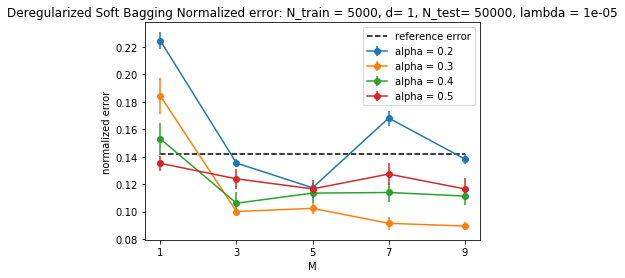

In [18]:
plt.hlines(0.1419,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Deregularized Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}, lambda = {lambda_}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.savefig("dereg_soft_bagging.png")
plt.show()


## Store results

In [19]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [20]:
import json
import datetime
with open(f'dereg_soft_bagging_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)